In [5]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


### EDA & Feature extraction

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [ ]:
train.continent.unique()

array(['south america', 'europe', 'africa', 'asia', 'oceania'],
      dtype=object)

In [ ]:
train.position.unique()

array(['ST', 'GK', 'DF', 'MF'], dtype=object)

In [ ]:
train.contract_until.unique()

array(['2021', '2020', '2019', '2023', '2022', '2024', '2026', '2018',
       '2025'], dtype=object)

In [85]:
train['contract_until'] = train.contract_until.astype(str).str[-4:]
train.contract_until.unique()

array(['2021', '2020', '2019', '2023', '2022', '2024', '2026', '2018',
       '2025'], dtype=object)

In [86]:
test['contract_until'] = test.contract_until.astype(str).str[-4:]

In [87]:
train['contract_until'] = train.contract_until.astype(int)
train.contract_until.dtype

dtype('int64')

In [88]:
test['contract_until'] = test.contract_until.astype(int)
test.contract_until.dtype

dtype('int64')

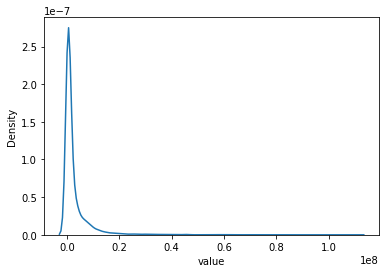

In [13]:
import seaborn as sns
sns.kdeplot(train.value)

In [89]:
train.value = np.log1p(train.value)

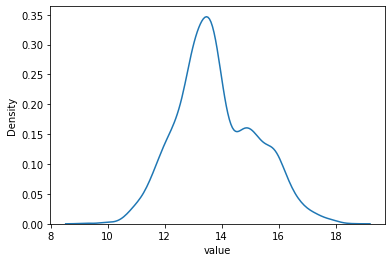

In [91]:
sns.kdeplot(train.value)

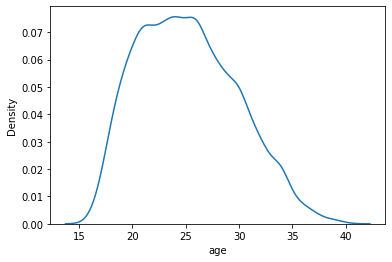

In [ ]:
sns.kdeplot(train.age)

In [92]:
X_tr = train.drop(['name', 'id', 'value'], axis=1)
y_tr = train['value']

In [93]:
test = test.drop(['name', 'id'], axis=1)

In [94]:
X_tr = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data=X_tr)

In [95]:
test = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data=test)

In [ ]:
X_tr.head()

,age,contract_until,reputation,stat_overall,stat_potential,stat_skill_moves,continent_africa,continent_asia,continent_europe,continent_oceania,continent_south america,position_DF,position_GK,position_MF,position_ST,prefer_foot_left,prefer_foot_right
0,31,2021,5.0,94,94,4.0,0,0,0,0,1,0,0,0,1,1,0
1,27,2020,4.0,91,93,1.0,0,0,1,0,0,0,1,0,0,0,1
2,31,2021,5.0,91,91,3.0,0,0,0,0,1,0,0,0,1,0,1
3,32,2020,4.0,91,91,3.0,0,0,1,0,0,1,0,0,0,0,1
4,25,2021,3.0,90,93,1.0,0,0,1,0,0,0,1,0,0,0,1


In [ ]:
test.head()

,age,contract_until,reputation,stat_overall,stat_potential,stat_skill_moves,continent_africa,continent_asia,continent_europe,continent_oceania,continent_south america,position_DF,position_GK,position_MF,position_ST,prefer_foot_left,prefer_foot_right
0,33,2022,5.0,94,94,5.0,0,0,1,0,0,0,0,0,1,0,1
1,26,2022,5.0,92,93,5.0,0,0,0,0,1,0,0,0,1,0,1
2,27,2023,4.0,91,92,4.0,0,0,1,0,0,0,0,1,0,0,1
3,27,2020,4.0,91,91,4.0,0,0,1,0,0,0,0,0,1,0,1
4,32,2020,4.0,91,91,4.0,0,0,1,0,0,0,0,1,0,0,1


### Building models

In [19]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=f48cb1945847152e331fd63ae9a66d63e08f7434524c334b8547dc05de27dfc3
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [20]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# use bayesian optimizer
from bayes_opt import BayesianOptimization

### KFold로 validation, 5가지 모델 사용

In [119]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)

rf_r = RandomForestRegressor(random_state=0, n_estimators=200)
gb_r = GradientBoostingRegressor(random_state=0, max_depth=5)
xgb_r = XGBRegressor(random_state=0, n_estimators=200)
lgbm_r = LGBMRegressor(random_state=0, n_estimators=200)
cb_r = CatBoostRegressor(random_state=0, n_estimators=200)

In [120]:
def train_model(model):
  scorelist = []
  test_pred = np.zeros((test.shape[0], 1)) # (3828,1)

  for tr_idx, val_idx in kf.split(X_tr, y_tr):
    tr_x, tr_y = X_tr.loc[tr_idx], y_tr.loc[tr_idx]
    val_x, val_y = X_tr.loc[val_idx], y_tr.loc[val_idx]

    model.fit(tr_x, tr_y)
    prediction = np.expm1(model.predict(val_x)) # value (target)을 (high skewness때문에) log 취했었으니까 다시 증폭
    print(prediction)
    score = np.sqrt(mean_squared_error(np.expm1(val_y), prediction))
    scorelist.append(score)

    # test set 예측
    # print(model.predict(test).shape) # (3828,) # 1darray # broadcast shape
    test_pred += np.expm1(model.predict(test)).reshape(-1,1)

  test_pred = test_pred / 5
  print(f"{model.__class__.__name__}의 5Fold 평균 RMSE는 {np.mean(scorelist)}")
  return test_pred

In [ ]:
rf_pred = train_model(rf_r)

In [ ]:
gb_pred = train_model(gb_r)

In [ ]:
xgb_pred = train_model(xgb_r)

In [ ]:
lgbm_pred = train_model(lgbm_r)

In [ ]:
cb_pred = train_model(cb_r)

In [ ]:
files.upload()

In [ ]:
submission = pd.read_csv('submission.csv')
submission.value = (rf_pred + gb_pred + xgb_pred + lgbm_pred + cb_pred) / 5
submission

In [ ]:
q1 = submission['value'].quantile(0.004)
q2 = submission['value'].quantile(0.99)

submission['value'] = submission['value'].apply(lambda x: x if x > q1 else x * 0.9)
submission['value'] = submission['value'].apply(lambda x: x if x < q2 else x * 1.1)

In [122]:
submission

,id,value
0,1,5.760319e+07
1,2,9.837119e+07
2,4,8.520684e+07
3,5,8.875024e+07
4,6,6.709223e+07
...,...,...
3823,16924,5.817693e+04
3824,16929,4.974653e+04
3825,16932,5.923267e+04
3826,16937,5.035582e+04


In [123]:
submission.to_csv('sub1.csv', index=False)

### Grid Search

In [106]:
params = {'depth':[2,3,4,5,6,7], 'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1, 0.25]}
grid_cb = GridSearchCV(CatBoostRegressor(random_state=0), params, cv=KFold(n_splits=5, shuffle=True, random_state=100),
                       scoring = 'neg_mean_squared_error', n_jobs=-1)
grid_cb.fit(X_tr, y_tr)

0:	learn: 1.2837102	total: 1.73ms	remaining: 1.73s
1:	learn: 1.1813204	total: 3.23ms	remaining: 1.61s
2:	learn: 1.0859155	total: 4.6ms	remaining: 1.53s
3:	learn: 0.9997594	total: 5.94ms	remaining: 1.48s
4:	learn: 0.9221619	total: 7.25ms	remaining: 1.44s
5:	learn: 0.8518453	total: 8.95ms	remaining: 1.48s
6:	learn: 0.7864283	total: 10.5ms	remaining: 1.49s
7:	learn: 0.7282305	total: 12.1ms	remaining: 1.5s
8:	learn: 0.6755757	total: 13.7ms	remaining: 1.51s
9:	learn: 0.6281842	total: 15.3ms	remaining: 1.52s
10:	learn: 0.5837209	total: 16.9ms	remaining: 1.52s
11:	learn: 0.5454316	total: 18.5ms	remaining: 1.52s
12:	learn: 0.5095967	total: 20ms	remaining: 1.52s
13:	learn: 0.4769258	total: 21.8ms	remaining: 1.54s
14:	learn: 0.4462682	total: 23.4ms	remaining: 1.54s
15:	learn: 0.4188052	total: 25.1ms	remaining: 1.54s
16:	learn: 0.3938121	total: 26.7ms	remaining: 1.54s
17:	learn: 0.3706319	total: 28.3ms	remaining: 1.54s
18:	learn: 0.3510646	total: 29.8ms	remaining: 1.54s
19:	learn: 0.3326554	total

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f4ef48e25d0>,
             n_jobs=-1,
             param_grid={'depth': [2, 3, 4, 5, 6, 7],
                         'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1,
                                           0.25]},
             scoring='neg_mean_squared_error')

In [108]:
best_params = grid_cb.best_params_

In [125]:
cb_r = CatBoostRegressor(random_state=0, **best_params)
cb_r.fit(X_tr, y_tr)

0:	learn: 1.2837102	total: 2.54ms	remaining: 2.54s
1:	learn: 1.1813204	total: 4.69ms	remaining: 2.34s
2:	learn: 1.0859155	total: 6.37ms	remaining: 2.12s
3:	learn: 0.9997594	total: 8.07ms	remaining: 2.01s
4:	learn: 0.9221619	total: 9.55ms	remaining: 1.9s
5:	learn: 0.8518453	total: 11.3ms	remaining: 1.87s
6:	learn: 0.7864283	total: 12.9ms	remaining: 1.83s
7:	learn: 0.7282305	total: 14.6ms	remaining: 1.8s
8:	learn: 0.6755757	total: 16.2ms	remaining: 1.78s
9:	learn: 0.6281842	total: 17.8ms	remaining: 1.76s
10:	learn: 0.5837209	total: 19.4ms	remaining: 1.75s
11:	learn: 0.5454316	total: 21.1ms	remaining: 1.73s
12:	learn: 0.5095967	total: 22.5ms	remaining: 1.71s
13:	learn: 0.4769258	total: 24.1ms	remaining: 1.7s
14:	learn: 0.4462682	total: 25.7ms	remaining: 1.68s
15:	learn: 0.4188052	total: 27.4ms	remaining: 1.68s
16:	learn: 0.3938121	total: 28.8ms	remaining: 1.67s
17:	learn: 0.3706319	total: 30.5ms	remaining: 1.66s
18:	learn: 0.3510646	total: 32.2ms	remaining: 1.66s
19:	learn: 0.3326554	tota

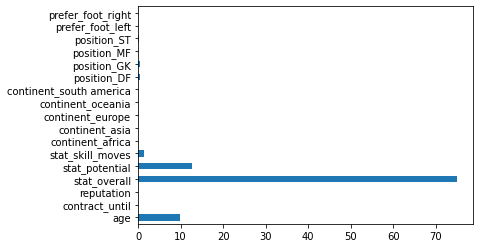

In [151]:
import matplotlib.pyplot as plt

feature_importances = pd.Series(cb_r.feature_importances_, index=X_tr.columns)
feature_importances.plot.barh() # 어엉..?

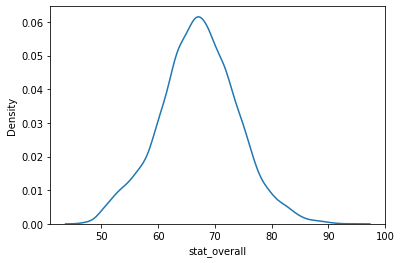

In [153]:
sns.kdeplot(X_tr.stat_overall)

In [154]:
X_tr.stat_overall.skew()

0.026723093963399714

In [152]:
from sklearn.preprocessing import StandardScaler

In [165]:
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr) # returns ndarray
# X_tr = pd.DataFrame(X_tr, columns=X_tr.columns)
X_tr = pd.DataFrame(X_tr)

In [163]:
X_tr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.249309,0.635952,9.130280,3.925708,3.674598,2.059652,-0.296326,-0.310844,-1.214182,-0.141365,1.906616,-0.674156,-0.356663,-0.789189,2.058813,1.806512,-1.806512
1,0.386357,-0.153420,6.770499,3.488041,3.507592,-1.806307,-0.296326,-0.310844,0.823600,-0.141365,-0.524489,-0.674156,2.803767,-0.789189,-0.485717,-0.553553,0.553553
2,1.249309,0.635952,9.130280,3.488041,3.173580,0.770999,-0.296326,-0.310844,-1.214182,-0.141365,1.906616,-0.674156,-0.356663,-0.789189,2.058813,-0.553553,0.553553
3,1.465046,-0.153420,6.770499,3.488041,3.173580,0.770999,-0.296326,-0.310844,0.823600,-0.141365,-0.524489,1.483336,-0.356663,-0.789189,-0.485717,-0.553553,0.553553
4,-0.045118,0.635952,4.410719,3.342152,3.507592,-1.806307,-0.296326,-0.310844,0.823600,-0.141365,-0.524489,-0.674156,2.803767,-0.789189,-0.485717,-0.553553,0.553553


In [166]:
params = {'depth':[2,3,4,5,6,7], 'learning_rate':[0.001, 0.005, 0.01, 0.05, 0.1, 0.25]}
grid_cb = GridSearchCV(CatBoostRegressor(random_state=0), params, cv=KFold(n_splits=5, shuffle=True, random_state=100),
                       scoring = 'neg_mean_squared_error', n_jobs=-1)
grid_cb.fit(X_tr, y_tr)

0:	learn: 1.2837102	total: 1.81ms	remaining: 1.81s
1:	learn: 1.1813204	total: 3.39ms	remaining: 1.69s
2:	learn: 1.0859155	total: 4.82ms	remaining: 1.6s
3:	learn: 0.9997594	total: 6.3ms	remaining: 1.57s
4:	learn: 0.9221619	total: 7.7ms	remaining: 1.53s
5:	learn: 0.8518453	total: 9.14ms	remaining: 1.51s
6:	learn: 0.7864283	total: 10.6ms	remaining: 1.5s
7:	learn: 0.7282305	total: 11.9ms	remaining: 1.48s
8:	learn: 0.6755757	total: 13.6ms	remaining: 1.5s
9:	learn: 0.6281842	total: 15.2ms	remaining: 1.5s
10:	learn: 0.5837209	total: 16.9ms	remaining: 1.52s
11:	learn: 0.5454316	total: 18.6ms	remaining: 1.53s
12:	learn: 0.5095967	total: 20.6ms	remaining: 1.56s
13:	learn: 0.4769258	total: 22.6ms	remaining: 1.59s
14:	learn: 0.4462682	total: 24.4ms	remaining: 1.6s
15:	learn: 0.4188052	total: 25.9ms	remaining: 1.59s
16:	learn: 0.3938121	total: 27.6ms	remaining: 1.6s
17:	learn: 0.3706319	total: 29.1ms	remaining: 1.59s
18:	learn: 0.3510646	total: 31ms	remaining: 1.6s
19:	learn: 0.3326554	total: 32.7m

AttributeError: ignored

In [167]:
best_params = grid_cb.best_params_
cb_r = CatBoostRegressor(random_state=100, **best_params)
cb_r.fit(X_tr, y_tr)

0:	learn: 1.2859847	total: 1.89ms	remaining: 1.89s
1:	learn: 1.1824584	total: 3.35ms	remaining: 1.67s
2:	learn: 1.0893328	total: 4.95ms	remaining: 1.65s
3:	learn: 1.0038554	total: 6.31ms	remaining: 1.57s
4:	learn: 0.9268150	total: 7.67ms	remaining: 1.52s
5:	learn: 0.8562234	total: 9.09ms	remaining: 1.51s
6:	learn: 0.7911810	total: 10.7ms	remaining: 1.52s
7:	learn: 0.7338240	total: 12.3ms	remaining: 1.52s
8:	learn: 0.6783486	total: 13.8ms	remaining: 1.52s
9:	learn: 0.6270629	total: 15.5ms	remaining: 1.53s
10:	learn: 0.5833285	total: 17ms	remaining: 1.52s
11:	learn: 0.5425450	total: 18.6ms	remaining: 1.53s
12:	learn: 0.5063653	total: 20ms	remaining: 1.52s
13:	learn: 0.4745365	total: 21.4ms	remaining: 1.51s
14:	learn: 0.4445649	total: 23.5ms	remaining: 1.54s
15:	learn: 0.4169479	total: 25.2ms	remaining: 1.55s
16:	learn: 0.3915001	total: 26.8ms	remaining: 1.55s
17:	learn: 0.3699564	total: 28.5ms	remaining: 1.56s
18:	learn: 0.3494768	total: 30.2ms	remaining: 1.56s
19:	learn: 0.3309326	total

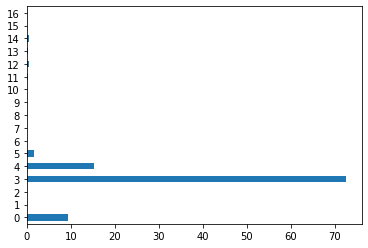

In [168]:
feature_importances = pd.Series(cb_r.feature_importances_)
feature_importances.plot.barh() # 어엉..?

In [170]:
pred_cat = np.expm1(cb_r.predict(test.values))

### bayesian optimization

In [111]:
pbounds = { 'learning_rate': (0.0001, 0.5),
            'n_estimators': (16, 1024),
            'max_depth': (3,10),   
            'subsample': (0.5, 1),  
            'colsample_bytree': (0.5, 1),   
            'gamma': (0, 5)}

kf = KFold(n_splits = 5, shuffle=True, random_state=50)

In [127]:
def optimizer(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma):
    
    par = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample': colsample_bytree,   
        'gamma': gamma,
        'n_jobs' : -1,
        'random_state' : 777
    }
    
    #xgb = XGBRegressor(**par)
    model.set_params(**par)

    score = cross_val_score(model, X_tr, y_tr, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    
    return np.mean(score)


In [128]:
model = XGBRegressor()
BO_xgb = BayesianOptimization(f = optimizer, pbounds = pbounds, random_state=0)

BO_xgb.maximize(init_points = 10, n_iter = 50)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.0175   |  0.7744   |  3.576    |  0.2411   |  6.814    |  443.0    |  0.8229   |
|  2        | -0.0239   |  0.7188   |  4.459    |  0.3855   |  5.684    |  814.1    |  0.7644   |
|  3        | -22.43    |  0.784    |  4.628    |  0.02851  |  3.61     |  36.38    |  0.9163   |
|  4        | -0.02158  |  0.8891   |  4.35     |  0.3914   |  8.594    |  481.2    |  0.8903   |
|  5        | -0.01414  |  0.5591   |  3.2      |  0.05743  |  9.613    |  542.0    |  0.7073   |
|  6        | -0.01641  |  0.6323   |  3.871    |  0.1825   |  6.979    |  34.94    |  0.8088   |
|  7        | -0.02067  |  0.806    |  3.085    |  0.3775   |  7.773    |  378.4    |  0.7185   |
|  8        | -0.00857  |  0.8488   |  0.3011   |  0.2667   |  7.694    |  228.1    |  0.5645   |
|  9        | -0.014

In [175]:
params = BO_xgb.max['params']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))

xgb = XGBRegressor(random_state=100, **params)
xgb.fit(X_tr.values, y_tr)
pred_xgb = np.expm1(xgb.predict(test.values))

[13:46:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [135]:
# 모든 과정 하나의 함수로 만들기

def bayesian_optimize(to_optimize): # 사용할 모델 전달

  def optimizer(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma): # 최적화할 함수
    
    par = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample': colsample_bytree,   
        'gamma': gamma,
        'n_jobs' : -1,
        'random_state' : 777
    }
    
    model.set_params(**par)

    score = cross_val_score(model, X_tr, y_tr, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    
    return np.mean(score)

  model = to_optimize
  BO = BayesianOptimization(f = optimizer, pbounds = pbounds, random_state=0) # bayesian optimization
  BO.maximize(init_points = 10, n_iter = 50)

  params = BO.max['params']
  params['max_depth'] = int(round(params['max_depth']))
  params['n_estimators'] = int(round(params['n_estimators']))

  best_model = to_optimize.set_params(random_state = 100, **params) # best parameter로 best model 생성
  best_model.fit(X_tr, y_tr)
  pred = np.expm1(best_model.predict(test))
  return pred

In [136]:
pred_lgbm = bayesian_optimize(LGBMRegressor())

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.005144 |  0.7744   |  3.576    |  0.2411   |  6.814    |  443.0    |  0.8229   |
|  2        | -0.005872 |  0.7188   |  4.459    |  0.3855   |  5.684    |  814.1    |  0.7644   |
|  3        | -0.3129   |  0.784    |  4.628    |  0.02851  |  3.61     |  36.38    |  0.9163   |
|  4        | -0.006091 |  0.8891   |  4.35     |  0.3914   |  8.594    |  481.2    |  0.8903   |
|  5        | -0.005224 |  0.5591   |  3.2      |  0.05743  |  9.613    |  542.0    |  0.7073   |
|  6        | -0.00801  |  0.6323   |  3.871    |  0.1825   |  6.979    |  34.94    |  0.8088   |
|  7        | -0.005656 |  0.806    |  3.085    |  0.3775   |  7.773    |  378.4    |  0.7185   |
|  8        | -0.005288 |  0.8488   |  0.3011   |  0.2667   |  7.694    |  228.1    |  0.5645   |
|  9        | -0.005

In [176]:
submission['value'] = (pred_cat + pred_xgb + pred_lgbm) / 3
q1 = submission['value'].quantile(0.0042)
q2 = submission['value'].quantile(0.99)

submission['value'] = submission['value'].apply(lambda x: x if x > q1 else x*0.77)
submission['value'] = submission['value'].apply(lambda x: x if x < q2 else x*1.1)

In [177]:
submission.to_csv('sub2.csv', index=False)